In [ ]:
#Reload an IPython extension by its module name.
%reload_ext autoreload
#2 is the code to reload ALL modules before running any code cell
%autoreload 2 
import cv2
import numpy as np
import os
import pathlib
from fastai.vision import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image as pilImg
import wls_filter
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

#Helper functions to read and write images

In [19]:
def imwrite(imageName,img):
    fileName = f'/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/{imageName}.png'   
    cv2.imwrite(fileName , img)         

#Loading the court segmentation model

In [3]:
path = Path('/Users/sandeep/Desktop/FinalYearProject/Python Files/courtSegmentation')


In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Other', '2Point', '3Point', 'Board', 'Freethrow', 'Layup'], dtype='<U9')

In [5]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Other']

def acc_courtSeg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [6]:
learn = load_learner('/Users/sandeep/Desktop/dataandmodles/models/courtSegmentation/u-net')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'fastai.vision.models.unet.DynamicUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modu

#Getting Prediction

In [13]:
test_img = open_image('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/Luka.png')
x = learn.predict(test_img)

#Converting the u-net output to a usable format

In [7]:
fig_args = {"dpi": 72 , 
            "scalefactor": 1
             }
fig = plt.figure()
figCanvasAgg = FigureCanvasAgg(fig)
renderer = figCanvasAgg.get_renderer()
figureImage = mpimg.FigureImage(fig)
def set_figsize(w,h):
    '''
    A helper function for apply_cmap
    note: img.shape= (H,W)
    '''
    xinch = w * fig_args["scalefactor"] / fig_args["dpi"]
    yinch = h * fig_args["scalefactor"] / fig_args["dpi"]
    fig.set_size_inches(xinch , yinch)

def rbga_to_brg(img):
    '''
    Helper function  for apply cmap
    Given: Image array in rbga 
    Returns: image array in brg 
    '''
    #from  rgba to rgb 
    img_rbg = img[0][:,:,0:3];
    img_bgr = np.squeeze(np.dstack([img_rbg[:,:,2] ,img_rbg[:,:,1] , img_rbg[:,:,0]]))    
    return img_bgr

def rotate_img(img):
    '''
    Helper function  for apply cmapp
    Return image that is rotated 180 degree anticlock-wise 
    '''
    return np.rot90(img , k=2)
def reflect_lr(img):
    '''
    Helper function  for apply cmap
    Returns image that is reflected across the y-axis
    '''
    return np.fliplr(img)
    
def apply_cmap(img_mask):
    set_figsize(img_mask.shape[1] , img_mask.shape[0])
    figureImage.set_data(img_mask)
    figureImageData = figureImage.make_image(renderer);
    figureImageData = rbga_to_brg(figureImageData)
    figureImageData = rotate_img(figureImageData)
    figureImageData = reflect_lr(figureImageData)
    return figureImageData
  
def get_class_mask(x):
    return image2np(x[0].data)    
    
    

<Figure size 432x288 with 0 Axes>

#Function that puts everything together

In [ ]:
def getCourtMask(img):
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    img = Image(pil2tensor(img, dtype=np.float32).div_(255))
    x = learn.predict(img)
    img_mask = get_class_mask(x)
    img_brg = apply_cmap(img_mask)
    return img_brg

#Demo on a video

In [8]:
videoPath = '/Users/sandeep/Desktop/dataandmodles/data/test2.mov'
savePath = '/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/lukaDrive'

cap  = cv2.VideoCapture(videoPath)
count = 0
while(cap.isOpened()):
    ret, img = cap.read()
    if ret:
        #converting the image to RGB image before sending it off to model
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        # converting the image to fastai image object
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        x = learn.predict(img)
        img_mask = get_class_mask(x)
        img_brg = apply_cmap(img_mask)
        cv2.imwrite(f'{savePath}/{count}.png' ,img_brg)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        cap.release()
        break
    count += 1 
cap.release()
cv2.destroyAllWindows()   

KeyboardInterrupt: 

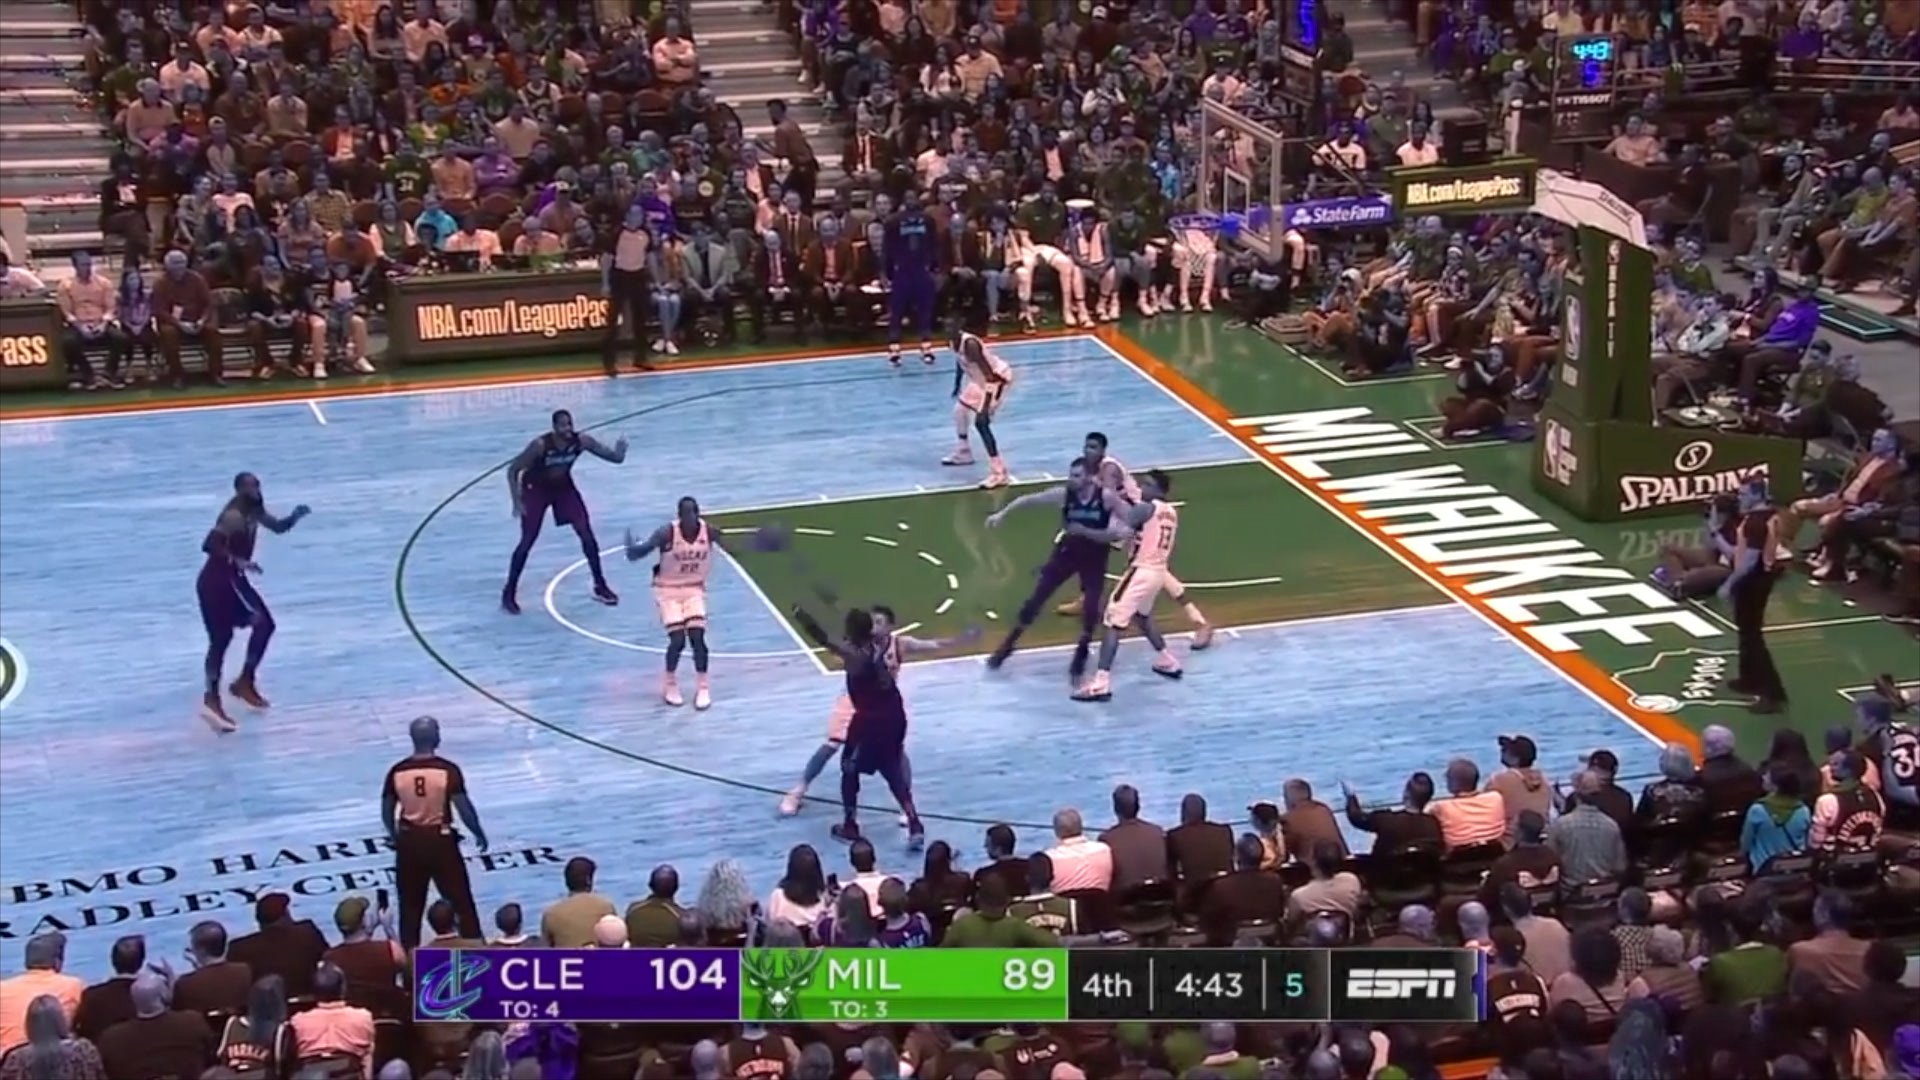

In [82]:
img

#Median Filter (testing)

In [63]:
 cmapped_img = cv2.medianBlur(cmapped_img  ,11)

In [64]:
#cv2.imwrite('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/LukaCourtSegPlotMedianBlur.png', cmapped_img)

True

#Color Mapping the prediction (TEST)

In [7]:
#test_img = open_image('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/Luka.png')
#x = learn.predict(test_img)

In [8]:
#img_mask = image2np(x[0].data)


In [91]:
#img_mask

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1]])

(720, 1280, 4)

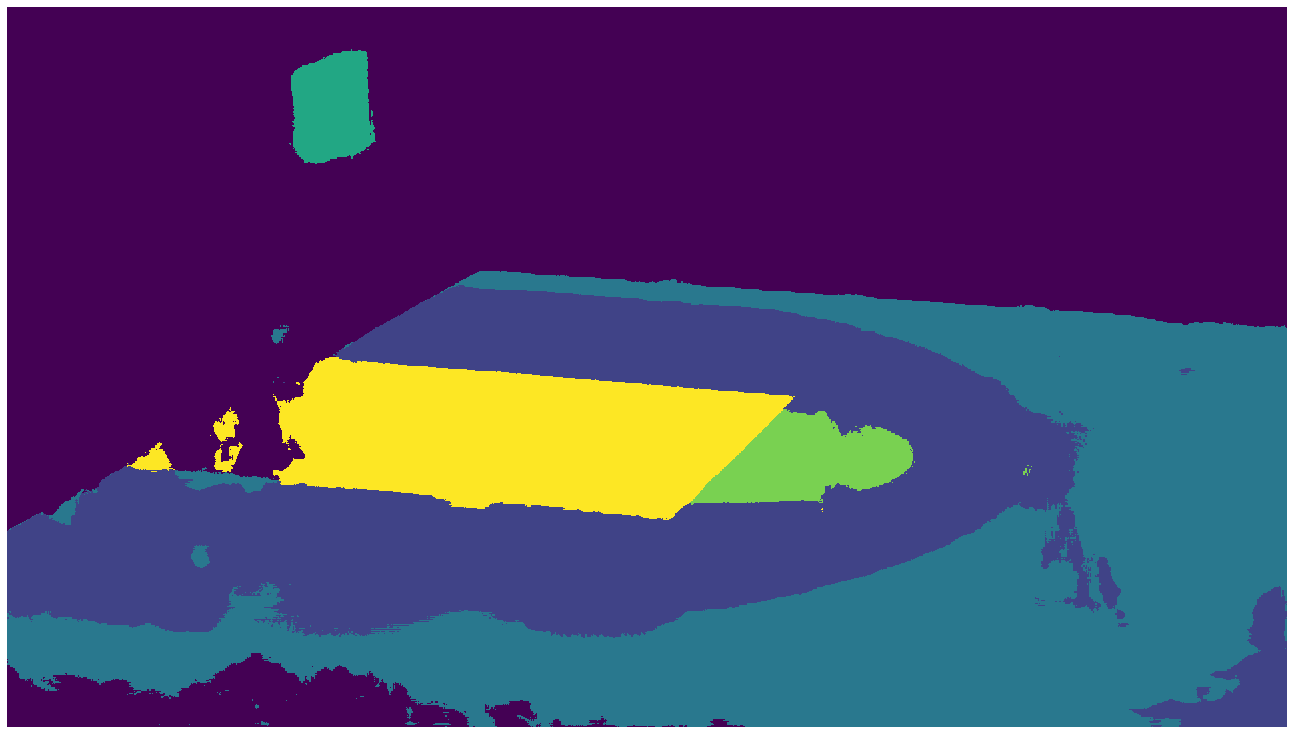

In [26]:
# xpixels = img_mask.shape[1]
# ypixels = img_mask.shape[0]
# dpi = 72
# scalefactor = 1
# xinch = xpixels * scalefactor / dpi
# yinch = ypixels * scalefactor / dpi
# fig = plt.figure(figsize=(xinch,yinch))
# ax = plt.axes([0, 0, 1, 1], frame_on=False, xticks=[], yticks=[])
# img_plot = plt.imshow(img_mask,interpolation='nearest')
# axesImage = img_plot.make_image('TkAgg');axesImage[0].shape

In [40]:
# axesImage

(array([[[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
     

In [94]:
# figureImage = mpimg.FigureImage(fig); figureImage
# figureImage.set_data(img_mask)

In [86]:
# figCanvasAgg = FigureCanvasAgg(fig)
# renderer = figCanvasAgg.get_renderer()

In [87]:
figureImageData = figureImage.make_image(renderer);figureImageData[0].shape

(720, 1280, 4)

In [88]:
#from  rgba to rgb 
figureImageData = figureImageData[0][:,:,0:3];figureImageData.shape


(720, 1280, 3)

In [90]:
figureImageData = np.squeeze(np.dstack([figureImageData[:,:,2] ,figureImageData[:,:,1] , figureImageData[:,:,0]]))

In [91]:
# cv2.imwrite('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/LukaCourtSegPlot.png', figureImageData)

True

In [16]:
axesImage = img_plot.make_image('TkAgg');axesImage[0].shape

(720, 1280, 4)

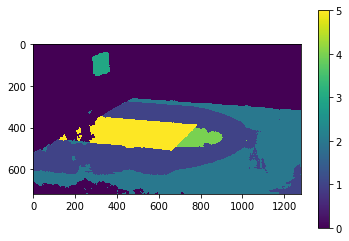

In [108]:
img_plot = plt.imshow(img_mask,interpolation='nearest')
plt.colorbar()


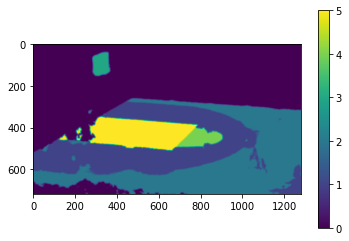

In [106]:
img_plot = plt.imshow(img_mask , interpolation="bicubic")
plt.colorbar()

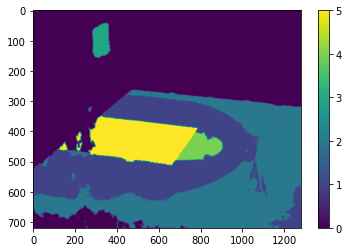

In [126]:
img_plot = plt.imshow(img_mask,interpolation='gaussian', aspect='auto')
plt.colorbar()

In [114]:
axesImage = img_plot.make_image('TkAgg');axesImage

(array([[[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255]],
 
        [[ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         [ 68,   1,  84, 255],
         ...,
         [ 64,  67, 135, 255],
         [ 64,  67, 135, 255],
     

In [115]:
axesImage[0].shape

(151, 268, 4)

(array([443485.,      0.,      0.,      0., ...,      0.,      0.,      0.,  59464.]),
 array([0.      , 0.019531, 0.039062, 0.058594, ..., 4.941406, 4.960938, 4.980469, 5.      ]),
 <a list of 256 Patch objects>)

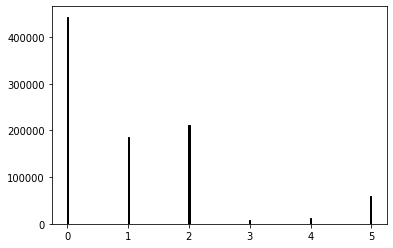

In [103]:
plt.hist(img_mask.ravel(),bins=256, range= (0.0,5.0) , fc='k' , ec='k')

In [99]:
cv2.imwrite('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/LukaSeg.png', image_bgr)

True

In [2]:
mask = cv2.imread("/Volumes/My Passport/FinalYearProjectData/ActionClassification2/Labels/The Best 3-Pointers from the 2016-2017 NBA Season 13-33 screenshot_mask.png")

In [5]:
mask.shape

(720, 1280, 3)

In [7]:
np.array(mask)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)

In [9]:
np.unique(mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [7]:
imgDir = "/Volumes/My Passport/FinalYearProjectData/CourtSegmentation/Labels"
for file in os.listdir(imgDir):
    if file[0] == "." and file[1] == "_":
        os.remove(imgDir+"/"+file)
        

In [9]:
len(os.listdir(imgDir))

268

#Team detection(Testing)

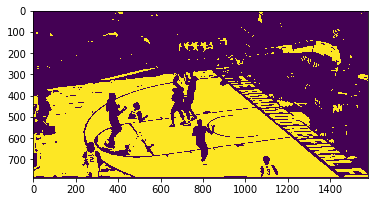

In [28]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/data/duke.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#HSV h,s,v
lower, upper = [0,0,200] , [255,255,255]
lower = np.array(lower, dtype = "uint8")
upper = np.array(upper, dtype = "uint8")
mask = cv2.inRange(img , lower , upper)
plt.imshow(mask)

In [50]:
imwrite('teamDetectionMask' , mask)

NameError: name 'imwrite' is not defined

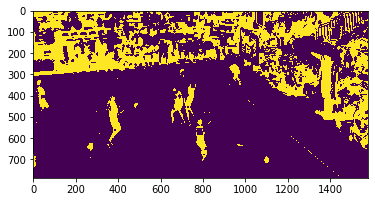

In [30]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/data/duke.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#HSV h,s,v
lower, upper = [0,0,0] , [180,255,60]
lower = np.array(lower, dtype = "uint8")
upper = np.array(upper, dtype = "uint8")
mask = cv2.inRange(img , lower , upper)
plt.imshow(mask)

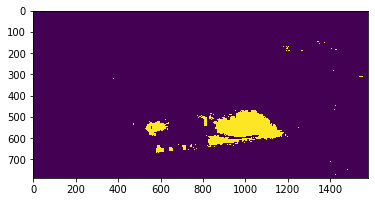

In [87]:
plt.imshow(mask)

In [27]:
output = cv2.bitwise_not(img, img, mask = mask)


In [28]:
imwrite('teamDetectionBitwiseNOT', output)

In [ ]:
plt.imshow(output)

In [92]:

def count_nonblack_np(img):
    """Return the number of pixels in img that are not black.
    img must be a Numpy array with colour values along the last axis.

    """
    return img.any(axis=-1).sum()

In [ ]:
resize = cv2.resize(img, (640,360))
hsv = cv2.cvtColor(resize, cv2.COLOR_BGR2HSV)
detect_team(hsv, show=True)